In [103]:
# @title Globals
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import mne
import torch
import torch.nn as nn
import torch.utils.data as Data
from datetime import datetime
import json

MNE_PATH = "/content/mne_data"
folder = "../data"

n_subjects = 109
n_runs = 14
n_channels = 64

# run_range = (3, n_runs+1)
run_range = (3, 10)
sub_range = (1, 3)

print_batches = False
print_every_n_epoch = 10

test_run_range = (10, 15)
test_sub_range = sub_range

# For some reason cpu is faster than MPS (metal performance shaders)
device = torch.device(
  'cuda' if torch.cuda.is_available()
  # else 'mps' if torch.backends.mps.is_available()
  else 'cpu'
)

print("PyTorch", torch.__version__, "using device", device)

central_channels = [3, 4, 5, 10, 11, 12, 17, 18, 19]
channel_selection = central_channels

PyTorch 2.1.0 using device cpu


In [104]:
# @title Install dependencies
%pip install mne numpy matplotlib torch torchvision pandas -q
# !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


In [105]:
# @title Def util functions

def getAnnotationMapping(run: int):
  res = {
    "T0": "rest"
  }
  if run in [3, 4, 7, 8, 11, 12]:
    res["T1"] = "left_fist"
    res["T2"] = "right_fist"
  if run in [5, 6, 9, 10, 13, 14]:
    res["T1"] = "both_fists"
    res["T2"] = "both_feet"
  return res

tasks = {
  "na": "unknown_task",
  "T0A": "baseline_eo", # baseline, eyes open
  "T0B": "baseline_ec", # baseline, eyes closed
  "T1": "mv_one", # open and close corresponding fist
  "T2": "im_one", # imagine opening and closing the corresponding fist
  "T3": "mv_two", # open and close both fists or both feet
  "T4": "im_two", # imagine opening and closing both fists or both feet
}
def getTaskFromRun(run: int) -> str:
  if run == 1: return tasks["T0A"]
  if run == 2: return tasks["T0B"]
  try: return tasks[f"T{(run-2)%4}"]
  except: return tasks["na"]

def transformRunData(n_subject, n_run):
  # Get data and standarize
  f_name = mne.datasets.eegbci.load_data(n_subject, n_run, path=MNE_PATH)[0]
  raw = mne.io.read_raw_edf(f_name, preload=True).load_data()
  mne.datasets.eegbci.standardize(raw)

  # Rename and get events
  raw.annotations.rename(getAnnotationMapping(n_run))
  events_from_annot, event_dict = mne.events_from_annotations(raw)

  # Get event durations
  # Set second (end) value on annotations to first (start) value of next item -1
  for i in range(len(events_from_annot)):
    if i+1<len(events_from_annot):
      events_from_annot[i][1] = events_from_annot[i+1][0]-1
    else:
      events_from_annot[i, 1] = len(raw)

  # Get data in np arr
  time_data = raw.get_data().transpose()

  def getPaddedRange(a, b):
    start = a
    end = b if b-a<720 else a+720
    ev = time_data[start:end]
    res = np.pad(ev, ((0, 720-len(ev)), (0,0)), 'wrap')
    return res

  # Save all events
  for ev in event_dict:
    events = mne.event.pick_events(events_from_annot, include=[event_dict[ev]])
    data = np.array([getPaddedRange(e[0],e[1])[:] for e in events])
    path = f'data/S{n_subject:03d}/R{n_run:02d}'
    os.makedirs(path, exist_ok=True)
    np.save(f'{path}/{ev}', data)

def genLogLine(epoch, num_epochs, step, num_steps, lr, lossItem, batch_correct_guesses, batch_size, epoch_correct_guesses, epoch_tries, total_correct_guesses, total_tries, test_accuracy):
  return f'\
{"   " if print_batches and step != 0 else "-> "}\
 Epoch [{epoch+1:02d}/{num_epochs}],\
 Batch [{step+1:02d}/{num_steps}],\
 LR: {lr:.3e},\
 Loss: {lossItem:.4f},\
 BatchAccuracy: {batch_correct_guesses/batch_size:.3f},\
 EpochAccuracy: {epoch_correct_guesses/epoch_tries:.3f},\
 TotalAccuracy: {total_correct_guesses/total_tries:.3f}\
 TestAccuracy: {test_accuracy:.3f}\
{"   " if print_batches and step != 0 else " <-"}'

In [106]:
# @title Copy dataset from Drive (Won't run unless modified)
# Run this block if you have the zip dataset in your drive (EEGMMIDB)
#   Remember to change the drive path if the zip is not in the root

if False:
  !mkdir -p mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0

  !unzip -u {folder}/eeg-motor-movementimagery-dataset-1.0.0 -d mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0

  !mv mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/files/* mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/.
  !rm -r mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/files

  from IPython.display import clear_output
  clear_output()

In [107]:
# @title ⚠️ Transforms and zips ALL data. Takes a LONG time, if you already have the archive don't run this cell, use the 3rd cell instead (Won't run unless modified)
if False:
  for s in range(109):
    for r in range(14):
      transformRunData(s+1, r+1)

  !zip -r transformed.zip data

  from IPython.display import clear_output
  clear_output()

In [108]:
# @title Unzip transformed dataset if not unzipped

!mkdir {folder}/transformed_data

!if [ -d {folder}/transformed_data ]; \
  then echo "Data exists in folder ({folder}/transformed_data)"; \
  else echo "Extracting from zip..."; unzip -o {folder}/transformed.zip -d {folder}/transformed_data; \
fi


mkdir: ../data/transformed_data: File exists


Data exists in folder (../data/transformed_data)


In [109]:
# @title Def test function

def testGru(t_gru, t_run_range, t_sub_range, t_channel_selection, t_params, debug=False):
  t_gru.eval()
  # Two events, single subject
  # t_r = np.load(f'{folder}/transformed_data/data/S{sub_range[0]:03d}/R{run_range[0]:02d}/rest.npy')
  # t_lf = np.load(f'{folder}/transformed_data/data/S{sub_range[0]:03d}/R{run_range[0]:02d}/left_fist.npy')
  # t_r = t_r[:t_lf.shape[0]]
  # test_data = np.concatenate((t_r, t_lf), axis=0)
  # test_tags = np.concatenate((np.tile(0, len(t_r)), np.tile(1, len(t_lf))))
  # if channel_selection != None:
  #   test_data = test_data[:, :, channel_selection]

  # Single event, multiple subjects
  test_data_raw = np.array([[
      ev
      for run in range(*t_run_range)
      for ev in np.load(f'{folder}/transformed_data/data/S{sub:03d}/R{run:02d}/rest.npy')
    ] for sub in range(*t_sub_range)
  ])
  test_tags = np.tile((np.arange(*t_sub_range)-1).reshape(t_sub_range[1]-1,t_sub_range[0]), (1,(t_run_range[1]-t_run_range[0])*15))
  if channel_selection != None:
    test_data_raw = test_data_raw[:, :, :, t_channel_selection]

  if debug:
    print("testing gru:", t_gru)
    print('test_data: ', test_data_raw.shape)
    print('test_tags: ', test_tags.shape)

  test_reshaped_data = test_data_raw.reshape(-1, t_params["cell_count"], t_params["input_size"])
  test_reshaped_tags = test_tags.reshape(-1)

  test_norm = torch.from_numpy(test_reshaped_data).type(torch.DoubleTensor).to(device).to(torch.float64)
  test_label = torch.from_numpy(test_reshaped_tags).type(torch.IntTensor).to(device).to(torch.int64)
  test_data = Data.TensorDataset(test_norm, test_label)
  test_loader = Data.DataLoader(dataset=test_data, batch_size=t_params["batch_size"], shuffle=True)

  test_correct_guesses = 0
  test_tries = 0

  for batch in enumerate(test_loader):
    step, (tr_x, tr_y) = batch
    acc_test = t_gru(tr_x)
    for i, t in enumerate(acc_test):
      if (tr_y[i] == torch.argmax(t)):
        test_correct_guesses += 1

    test_tries += t_params["batch_size"]

  if debug: print(f'TestAccuracy: {test_correct_guesses/test_tries:.3f}')
  return (test_correct_guesses/test_tries, {
    "subjects": test_data_raw.shape[0],
    "events": test_data_raw.shape[1],
  })


In [110]:
# @title GRU with N classes (N = number of subjects)

class GRU(nn.Module):
  def __init__(self, params):
    super(GRU, self).__init__()

    self.gru_layer = nn.GRU(
        params["input_size"],
        params["hidden_size"],
        params["num_layers"],
        bias=params["gru"]["bias"],
        batch_first=True,
        bidirectional=params["gru"]["bidirectional"],
        dropout=params["gru"]["dropout"],
        device=device
    )
    self.out = nn.Linear(params["hidden_size"]*(2 if params["gru"]["bidirectional"] else 1), params["num_classes"])

  def forward(self, x):
    r_out, t = self.gru_layer(x, None)
    test_output = self.out(r_out[:,-1,:])
    return test_output


def trainGru(train_data, train_tags, params, test_info, debug = False, save_gru = True):
  test_run_range, test_sub_range, channel_selection = test_info
  reshaped_data = train_data.reshape(-1, params["cell_count"], params["input_size"])
  reshaped_tags = train_tags.reshape(-1)

  if debug:
    print(reshaped_data.shape, reshaped_data.dtype)
    print(reshaped_tags.shape, reshaped_tags.dtype)

  tr_norm = torch.from_numpy(reshaped_data).type(torch.DoubleTensor).to(device).to(torch.float64)
  tr_label = torch.from_numpy(reshaped_tags).type(torch.IntTensor).to(device).to(torch.int64)
  tr_data = Data.TensorDataset(tr_norm, tr_label)
  tr_loader = Data.DataLoader(dataset=tr_data, batch_size=params["batch_size"], shuffle=True)

  gru = GRU(params)
  gru.to(device)
  gru.double()
  if debug:
    print(gru)

  optimizer = torch.optim.Adam(
      gru.parameters(),
      lr=params["learning_rate"],
      betas=params["optimizer"]["betas"],
      eps=params["optimizer"]["eps"],
      weight_decay=params["optimizer"]["weight_decay"],
      amsgrad=params["optimizer"]["amsgrad"],
      foreach=params["optimizer"]["foreach"],
      maximize=params["optimizer"]["maximize"],
      capturable=params["optimizer"]["capturable"],
      differentiable=params["optimizer"]["differentiable"],
      fused=params["optimizer"]["fused"]
    )
  loss_func = nn.CrossEntropyLoss(label_smoothing=0.95).to(device)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=params["max_learning_rate"],
    steps_per_epoch=len(tr_loader),
    epochs=params["num_epochs"],
    div_factor=params["div_factor"],
    final_div_factor=params["final_div_factor"],
    pct_start=params["pct_start"],
  )


  loss_min = float('inf')
  loss_max = float('-inf')
  loss_sum = 0
  batch_correct_guesses = 0
  epoch_correct_guesses = 0
  epoch_tries = 0
  total_tries = 0
  total_correct_guesses = 0
  t_acc = 0.0

  train_start = datetime.now()
  filename = train_start.strftime("%Y-%m-%dT%H:%M")

  with open(f'{folder}/trains/{filename}.csv', 'w') as f:
    f.write("Epoch, Batch, LR, Loss, BatchAccuracy, EpochAccuracy, TotalAccuracy, TestAccuracy\n")
    for epoch in range(params["num_epochs"]):
      epoch_correct_guesses = 0
      epoch_tries = 0
      for batch in enumerate(tr_loader):
        step, (tr_x, tr_y) = batch
        gru.train()
        output = gru(tr_x)
        loss = loss_func(output, tr_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        gru.eval()
        batch_correct_guesses = 0
        acc_test = gru(tr_x)
        for i, t in enumerate(acc_test):
          if (tr_y[i] == torch.argmax(t)):
            batch_correct_guesses += 1

        total_correct_guesses += batch_correct_guesses
        total_tries += params["batch_size"]
        epoch_correct_guesses += batch_correct_guesses
        epoch_tries += params["batch_size"]

        
        loss_min = min(loss_min, loss.item())
        loss_max = max(loss_max, loss.item())
        loss_sum += loss.item()

        logLine = genLogLine(
          epoch,
          params["num_epochs"],
          step,
          len(tr_loader),
          scheduler.get_last_lr()[0],
          loss.item(),
          batch_correct_guesses,
          params["batch_size"],
          epoch_correct_guesses,
          epoch_tries,
          total_correct_guesses,
          total_tries,
          t_acc
        )

        if debug and (print_batches or ((epoch+1)%print_every_n_epoch==0 and step==0)):
          print(logLine)
        if save_gru:
          f.write(f"{epoch+1}, {step+1}, {scheduler.get_last_lr()[0]}, {loss.item():.4f}, {batch_correct_guesses/params['batch_size']:.3f}, {epoch_correct_guesses/epoch_tries:.3f}, {total_correct_guesses/total_tries:.3f}, {t_acc:.3f}\n")
      t_acc, _ = testGru(gru, test_run_range, test_sub_range, channel_selection, params, False)
  train_end = datetime.now()

  test_acc, ts_data = testGru(gru, test_run_range, test_sub_range, channel_selection, params, debug)

  results = {
    "train_start": train_start.strftime("%Y-%m-%dT%H:%M"),
    "train_end": train_end.strftime("%Y-%m-%dT%H:%M"),
    "train_duration": str(train_end-train_start),
    "filename": filename,
    "loss": {
      "min": loss_min,
      "max": loss_max,
      "avg": loss_sum/(params["num_epochs"]*len(tr_loader)),
      "final": loss.item()
    },
    "accuracy": total_correct_guesses/total_tries,
    "last_epoch_accuracy": epoch_correct_guesses/epoch_tries,
    "test_accuracy": test_acc,
    "channel_selection": channel_selection,
    "channel_count": len(channel_selection),
    "train_data": {
      "subjects": train_data.shape[0],
      "events": train_data.shape[1],
    },
    "test_data": ts_data,
  }

  if save_gru:
    save = {
      "params": params,
      "results": results
    }
    with open(f'{folder}/trains/{filename}.json', 'w') as j:
      json.dump(save, j, indent=2)
    torch.save(gru, f'{folder}/trains/{filename}.pt')

  print(f'Results [{filename}]: Acc: {results["accuracy"]:.3f}, LastEpochAcc: {results["last_epoch_accuracy"]:.3f}, TestAcc: {results["test_accuracy"]:.3f}')
  return filename

In [111]:
# @title Import data

# Two events, single subject
# r = np.load(f'{folder}/transformed_data/data/S{sub_range[0]:03d}/R{run_range[0]:02d}/rest.npy')
# lf = np.load(f'{folder}/transformed_data/data/S{sub_range[0]:03d}/R{run_range[0]:02d}/left_fist.npy')
# r = r[:lf.shape[0]]
# data = np.concatenate((r, lf), axis=0)
# tags = np.concatenate((np.tile(0, len(r)), np.tile(1, len(lf))))
# if channel_selection != None:
#   data = data[:, :, channel_selection]

# Single event, multiple subjects
data = np.array([[
    ev
    for run in range(*run_range)
    for ev in np.load(f'{folder}/transformed_data/data/S{sub:03d}/R{run:02d}/rest.npy')
  ] for sub in range(*sub_range)
])
tags = np.tile((np.arange(*sub_range)-1).reshape(sub_range[1]-1,sub_range[0]), (1,(run_range[1]-run_range[0])*15))
# tags = np.tile([0]+[1]*(sub_range[1]-sub_range[0]-1), ((run_range[1]-run_range[0])*15,1)).transpose()
if channel_selection != None:
  data = data[:, :, :, channel_selection]

print('data: ', data.shape)
print('tags: ', tags.shape)
# (10, 180, 720, 64)
# (10 subjects, 180 events/subject, 720 samples/event, 64 channels/sample)

data:  (2, 105, 720, 9)
tags:  (2, 105)


In [112]:
# @title Initialize parameters
save_gru = True
# Hyper-params
params = {
  "batch_size": 3, # 1
  "cell_count": 4, # 1
  "num_layers": 1, # 1
  "input_size": None,
  "hidden_size": 100, # ?
  "num_classes": sub_range[1]-sub_range[0],
  # "num_classes": 2,
  "num_epochs": 200,
  "learning_rate": 1e-2, # 1e-3
  "max_learning_rate": 1e-2,
  "div_factor": 1, # 25
  "final_div_factor": 10, # 1e4
  "pct_start": 0.5, # 0.3
  "optimizer": {
    "betas": (0.9, 0.999), # (0.9, 0.999)
    "eps": 1e-08, # 1e-08
    "weight_decay": 0, # 0
    "amsgrad": False, # False
    "foreach": None, # None
    "maximize": False, # False
    "capturable": False, # False
    "differentiable": False, # False
    "fused": None # None
  },
  "gru": {
    "bias": True, # True
    "bidirectional": True, # False
    "dropout": 0, # 0
  }
}
params["input_size"] = (data.shape[-2]//params["cell_count"])*data.shape[-1]


In [113]:
lrs = [params["learning_rate"]]
filenames = []

for lr in lrs:
    print(f'learning rate: {lr}')
    params["learning_rate"] = lr
    fn = trainGru(data, tags, params, (test_run_range, test_sub_range, channel_selection), debug=True, save_gru=True)
    filenames.append(fn)
    print()

learning rate: 0.01
(210, 4, 1620) float64
(210,) int64
GRU(
  (gru_layer): GRU(1620, 100, batch_first=True, bidirectional=True)
  (out): Linear(in_features=200, out_features=2, bias=True)
)
->  Epoch [10/200], Batch [01/70], LR: 1.000e-02, Loss: 0.6945, BatchAccuracy: 0.333, EpochAccuracy: 0.333, TotalAccuracy: 0.581 TestAccuracy: 0.573 <-
->  Epoch [20/200], Batch [01/70], LR: 1.000e-02, Loss: 0.6926, BatchAccuracy: 1.000, EpochAccuracy: 1.000, TotalAccuracy: 0.682 TestAccuracy: 0.587 <-
->  Epoch [30/200], Batch [01/70], LR: 1.000e-02, Loss: 0.6920, BatchAccuracy: 1.000, EpochAccuracy: 1.000, TotalAccuracy: 0.777 TestAccuracy: 0.733 <-
->  Epoch [40/200], Batch [01/70], LR: 1.000e-02, Loss: 0.6919, BatchAccuracy: 1.000, EpochAccuracy: 1.000, TotalAccuracy: 0.833 TestAccuracy: 0.773 <-
->  Epoch [50/200], Batch [01/70], LR: 1.000e-02, Loss: 0.6919, BatchAccuracy: 1.000, EpochAccuracy: 1.000, TotalAccuracy: 0.867 TestAccuracy: 0.753 <-
->  Epoch [60/200], Batch [01/70], LR: 1.000e-02,

{
  "params": {
    "batch_size": 3,
    "cell_count": 4,
    "num_layers": 1,
    "input_size": 1620,
    "hidden_size": 100,
    "num_classes": 2,
    "num_epochs": 200,
    "learning_rate": 0.01,
    "max_learning_rate": 0.01,
    "div_factor": 1,
    "final_div_factor": 10,
    "pct_start": 0.5,
    "optimizer": {
      "betas": [
        0.9,
        0.999
      ],
      "eps": 1e-08,
      "weight_decay": 0,
      "amsgrad": false,
      "foreach": null,
      "maximize": false,
      "capturable": false,
      "differentiable": false,
      "fused": null
    },
    "gru": {
      "bias": true,
      "bidirectional": true,
      "dropout": 0
    }
  },
  "results": {
    "train_start": "2023-11-13T22:53",
    "train_end": "2023-11-13T22:56",
    "train_duration": "0:02:50.474027",
    "filename": "2023-11-13T22:53",
    "loss": {
      "min": 0.691896659394152,
      "max": 0.7588882646706476,
      "avg": 0.6920807185564261,
      "final": 0.6918967005184535
    },
    "accuracy

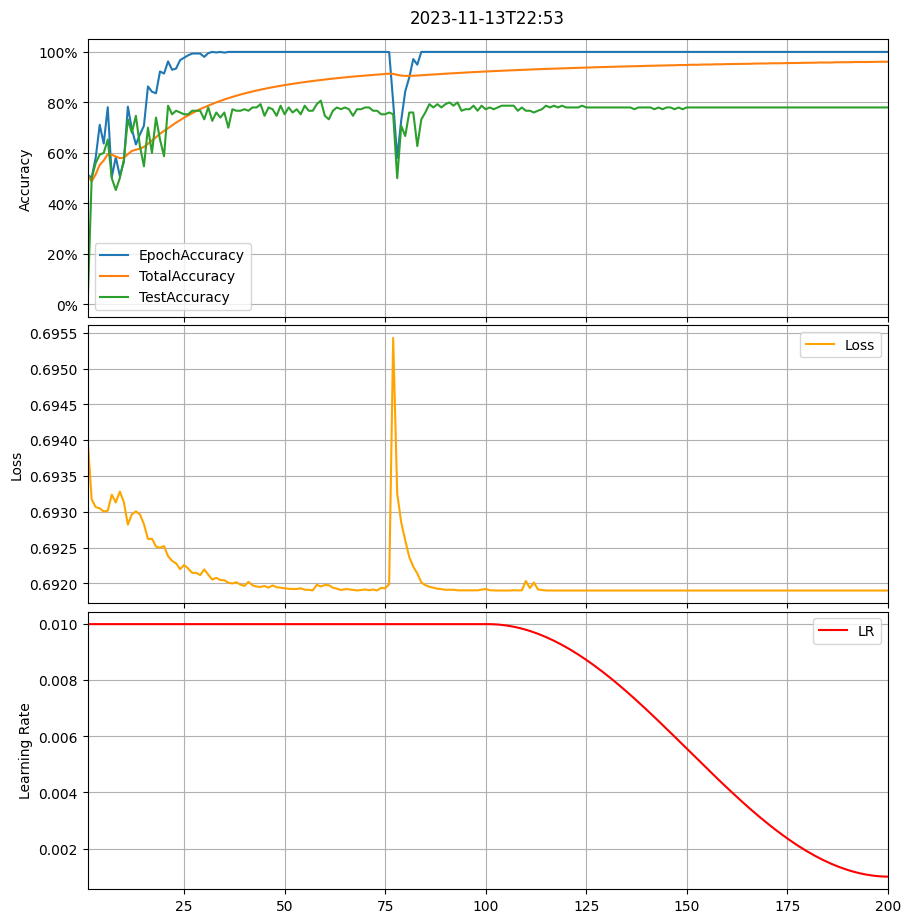

In [114]:
# @title Plot results
# filenames = ["2023-11-10T19:56"]

filename = filenames[0]
# filename = "2023-11-11T14:00"
# filename = "2023-11-11T16:12" // best (static lr)

trainInfo = json.load(open(f'{folder}/trains/{filename}.json', 'r'))
print(json.dumps(trainInfo, indent=2))

plt_data = pd.read_csv(f"{folder}/trains/{filename}.csv", skipinitialspace=True)
plt_data = plt_data.groupby("Epoch").mean()

ylabels = ["Accuracy", "Loss"] + (["Learning Rate"] if "LR" in plt_data.columns else [])

fig, axs = plt.subplots(len(ylabels), 1, figsize=(10, 10))
fig.suptitle(filename)
fig.tight_layout(pad=1)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9, 
                    top=0.95, 
                    wspace=0,
                    hspace=0.03)

axs[0].plot(plt_data.index, plt_data["EpochAccuracy"], label="EpochAccuracy")
axs[0].plot(plt_data.index, plt_data["TotalAccuracy"], label="TotalAccuracy")
if "TestAccuracy" in plt_data.columns:
  axs[0].plot(plt_data.index, plt_data["TestAccuracy"], label="TestAccuracy")
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[0].set_xticklabels([])

axs[1].plot(plt_data.index, plt_data["Loss"], label="Loss", color="orange")
axs[1].set_xticklabels([])
# axs[1].set_yscale("log")

if "LR" in plt_data.columns:
  axs[2].plot(plt_data.index, plt_data["LR"], label="LR", color="red")
  # axs[2].set_yscale("log")

for i, ax in enumerate(axs):
  ax.set_ylabel(ylabels[i])
  ax.margins(x=0)
  ax.grid(True)
  ax.legend()
plt.subplots_adjust(wspace=None, hspace=None)

plt.show()


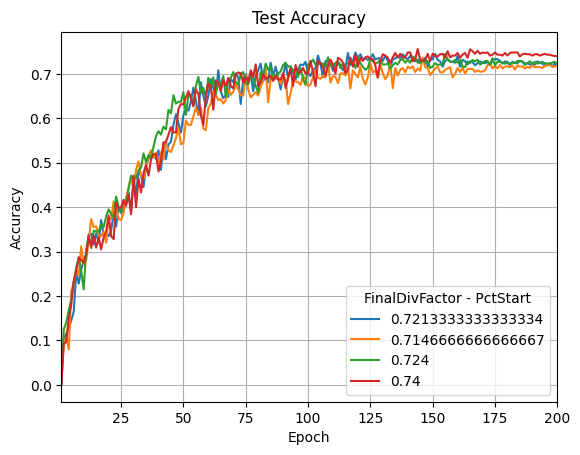

In [115]:
filenames = [
  "2023-11-11T18:14",
  "2023-11-11T18:27",
  "2023-11-11T18:40",
  "2023-11-11T18:53",
]


plot_data = [pd.read_csv(f"{folder}/trains/{filename}.csv", skipinitialspace=True) for filename in filenames]
plot_data = [data.groupby("Epoch").mean() for data in plot_data]
column_names = [f"{p['test_accuracy']}" for p in [json.load(open(f'{folder}/trains/{filename}.json', 'r'))["results"] for filename in filenames]]
# column_names = [0, 0.5, 0.7, 0.3, 0.9]
# join dataframes on epoch (only total accuracy column)
plot_data = pd.concat([data["TestAccuracy"] for data in plot_data], axis=1)
# rename columns
plot_data.columns = column_names
# plot
plot_data.plot()

ax = plt.gca()
# ax.set_yscale("log")
ax.set_ylabel("Accuracy")
ax.margins(x=0)
ax.grid(True)
ax.legend(title="FinalDivFactor - PctStart")
ax.set_title("Test Accuracy")

plt.show()
